# Yelp Dataset Analysis

## Introduction

<img src="Yelp_RGB_fullcolor_outline.png" width="100">
**Yelp** is a crowd-sourced review forum, as well as an American multinational corporation headquartered in San Francisco, California. It develops, hosts and markets [Yelp.com](https://www.yelp.com) and the Yelp mobile app, which publish **crowd-sourced reviews** about local businesses, as well as the online reservation service Yelp Reservations. The company also trains small businesses in how to respond to reviews, hosts social events for reviewers, and provides data about businesses, including health inspection scores.
https://en.wikipedia.org/wiki/Yelp

### Relationship with businesses
A Harvard Business School study published in 2011 found that each "star" in a Yelp rating affected the business owner's sales by 5–9 percent. A 2012 study by two Berkeley economists found that an increase from 3.5 to 4 stars on Yelp resulted in a 19 percent increase in the chances of the restaurant being booked during peak hours. A 2014 survey of 300 small business owners done by Yodle found that 78 percent were concerned about negative reviews. Also, 43 percent of respondents said they felt online reviews were unfair, because there is no verification that the review is written by a legitimate customer.
https://en.wikipedia.org/wiki/Yelp#Relationship_with_businesses

### Yelp Dataset

Yelp has released part of their data to raise an activity called [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge), which offers a chance for people to conduct research or analysis and discover what insights lie hidden in their data. Due to the size of data, this project only chooses their data partially in a zip file called **'dataset.zip'**, which contains four json files including:

- business.json - Contains business data including location data, attributes, and categories.
- user.json - User data including the user's friend mapping and all the metadata associated with the user.
- review.json - Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
- photos.json - This file is formatted as a JSON list of objects.

I have deleted some unuseful key value in some json files for this project, all the introduction of json files and explication of attributes can be found in https://www.yelp.com/dataset/documentation/json.

In [35]:
# Set up
import json
import zipfile
import os
import pandas as pd
import datetime
import utils
import matplotlib.pyplot as plt

# Ensure that Pandas shows at least 200 characters in columns.
pd.set_option('max_colwidth', 200)

# This style emulates the look and feel of the famous data journalist Nate Silver's site.
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set()
sns.set_context("talk")

utils.help_directory('dataset.zip')

In [36]:
def load_file(path):
    # Create a dataframe
    with open(path) as file:
        l = []
        for r in file:
            l.append(r)
        return pd.DataFrame.from_records(map(json.loads, l))

## Reviews

In [37]:
reviews = load_file('dataset/review.json')
reviews.drop(['business_id', 'user_id'], axis=1, inplace=True)
reviews = reviews[['review_id', 'date', 'stars', 'text', 'cool', 'funny', 'useful']]
reviews['date'] = reviews['date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
reviews.head()

,review_id,date,stars,text,cool,funny,useful
0,v0i_UHJMo_hPBq9bxWvW4w,2016-05-28,5,"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you...",0,0,0
1,vkVSCC7xljjrAI4UGfnKEQ,2016-05-28,5,Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very he...,0,0,0
2,n6QzIUObkYshz4dz2QRJTw,2016-05-28,5,Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and...,0,0,0
3,MV3CcKScW05u5LVfF6ok0g,2016-05-28,5,Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They...,0,0,0
4,IXvOzsEMYtiJI0CARmj77Q,2016-05-28,4,"Love coming here. Yes the place always needs the floor swept but when you give out peanuts in the shell how won't it always be a bit dirty. \n\nThe food speaks for itself, so good. Burgers are ma...",0,0,0


In [38]:
# Incluing 100000 reviews from yelp users.
reviews.shape

(100000, 7)

### Reviews-stars

In [39]:
review_stars = reviews['stars'].value_counts()
review_stars_percent = review_stars.apply(lambda i : i / len(reviews))
review_stars_percent

5    0.42720
4    0.23897
1    0.13267
3    0.11807
2    0.08309
Name: stars, dtype: float64

When we count the number of reviews for different stars, it is clear to see that most people `42.7%` tend to give 5-star or 4-star ratings `23.9%`, which means that for about `66.6%` people are at least satisfied with their businesses. And then, the third highest rating star is 1-star with `13.3%`. 

NBC news published an article [Online reviews: Here's what's behind all those 5 star ratings](https://www.nbcnews.com/better/business/does-five-star-online-review-really-mean-product-good-ncna870901), it stated that people nowadays tend to give either perfect reviews like 5-star and 4-star or offer awful ratings such as 1-star. Sometimes ratings can't reveal the information matters to people because of fake or misleading reviews that can bump star ratings up or down. 

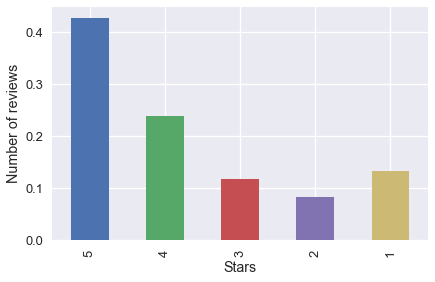

In [40]:
review_stars_percent.sort_index(ascending=False).plot('bar')
plt.ylabel('Number of reviews')
plt.xlabel('Stars');

### Reviews-Sentimenet Analysis

It turns out that we can use the words in texts to calculate a measure of the sentiment of the people from their reviews. For example, the sentence "Love coming here" has positive sentiment, whereas the sentence "Food is very bland" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "Love coming here." is more positive than "Like coming here."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of users' reviews. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. For example:

In [41]:
print(''.join(open("vader_lexicon.txt").readlines()[:5]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]



In [42]:
# Index is the token or the word itself, first column is the polarity of the word, or how positive / negative it is.
polarity = pd.read_table("vader_lexicon.txt",header=None).loc[:, 1].values
index = pd.read_table("vader_lexicon.txt",header=None).loc[:, 0].values
sent = pd.DataFrame({'polarity':polarity})
sent.index = index
sent.head()

,polarity
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


Now, let's use this lexicon to calculate the overall sentiment for each of review's text. Here's the basic idea:

1. For each review's text, find the sentiment of each word.
2. Calculate the sentiment of each review's text by taking the sum of the sentiments of its words.

In [43]:
reviews['text'] = reviews['text'].str.lower()

## Users

In [44]:
users = load_file('dataset/users.json')
users.drop(users.columns[[1,2,3,4,5,6,7,8,9,10,11,13,15]], axis=1, inplace=True)
users = users[['user_id', 'name', 'yelping_since', 'average_stars', 'review_count', 'fans', 'cool', 'funny', 'useful']]
users.head()

,user_id,name,yelping_since,average_stars,review_count,fans,cool,funny,useful
0,oMy_rEb0UBEmMlu-zcxnoQ,Johnny,2014-11-03,4.67,8,0,0,0,0
1,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,2013-09-24,3.70,10,0,0,0,0
2,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,2017-03-02,2.00,1,0,0,0,0
3,mBneaEEH5EMyxaVyqS-72A,Mark,2015-03-13,4.67,6,0,0,0,0
4,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,2016-09-08,4.67,3,0,0,0,0


## Businesses

In [46]:
businesses = load_file('dataset/business.json')
businesses.drop(['neighborhood', 'address', 'hours'], axis=1, inplace=True)
businesses = businesses[['business_id', 'name', 'is_open', 'stars', 'review_count', 'categories', 'attributes', 'state', 'city', 'postal_code', 'latitude', 'longitude']]
businesses.head()

,business_id,name,is_open,stars,review_count,categories,attributes,state,city,postal_code,latitude,longitude
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,1,4.0,22,"[Dentists, General Dentistry, Health & Medical, Oral Surgeons, Cosmetic Dentists, Orthodontists]","{'AcceptsInsurance': True, 'ByAppointmentOnly': True, 'BusinessAcceptsCreditCards': True}",AZ,Ahwatukee,85044,33.330690,-111.978599
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,1,3.0,11,"[Hair Stylists, Hair Salons, Men's Hair Salons, Blow Dry/Out Services, Hair Extensions, Beauty & Spas]","{'BusinessParking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'HairSpecializesIn': {'coloring': True, 'africanamerican': False, 'curly': True, 'perms': T...",PA,McMurray,15317,40.291685,-80.104900
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,1,1.5,18,"[Departments of Motor Vehicles, Public Services & Government]",{},AZ,Phoenix,85017,33.524903,-112.115310
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,0,3.0,9,"[Sporting Goods, Shopping]","{'BusinessAcceptsCreditCards': True, 'RestaurantsPriceRange2': 2, 'BusinessParking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'BikeParking': True}",AZ,Tempe,85282,33.383147,-111.964725
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,1,3.5,116,"[American (New), Nightlife, Bars, Sandwiches, American (Traditional), Burgers, Restaurants]","{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseLevel': 'average', 'RestaurantsAttire': 'casual', 'BusinessAcceptsCreditCards': True, 'Music': {'dj': False, 'background_music': True, 'no_music': Fals...",OH,Cuyahoga Falls,44221,41.119535,-81.475690


# Photos

In [47]:
photos = load_file('dataset/photos.json')
photos = photos[['photo_id', 'business_id', 'label', 'caption']]
photos.head()

,photo_id,business_id,label,caption
0,soK1szeyan202jnsGhUDmA,OnAzbTDn79W6CFZIriqLrA,inside,
1,dU7AyRB_fHOZkflodEyN5A,OnAzbTDn79W6CFZIriqLrA,inside,
2,6T1qlbBdKkXA1cDNqMjg2g,OnAzbTDn79W6CFZIriqLrA,outside,
3,lHhMNhCA7rAZmi-MMfF3ZA,OnAzbTDn79W6CFZIriqLrA,inside,Bakery area
4,oHSCeyoK9oLIGaCZq-wRJw,XaeCGHZzsMwvFcHYq3q9sA,food,
